## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,mean_squared_error

from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Activation, Dense, Reshape, Conv2D, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [4]:
tf.compat.v1.reset_default_graph()
tf.random.set_seed(51)
tf.keras.backend.clear_session()

Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [5]:
project_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Project/DogBreed_Classification/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [7]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [8]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [9]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [10]:
labels_df = pd.read_csv('/content/labels.csv')

In [11]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [12]:
labels_df['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

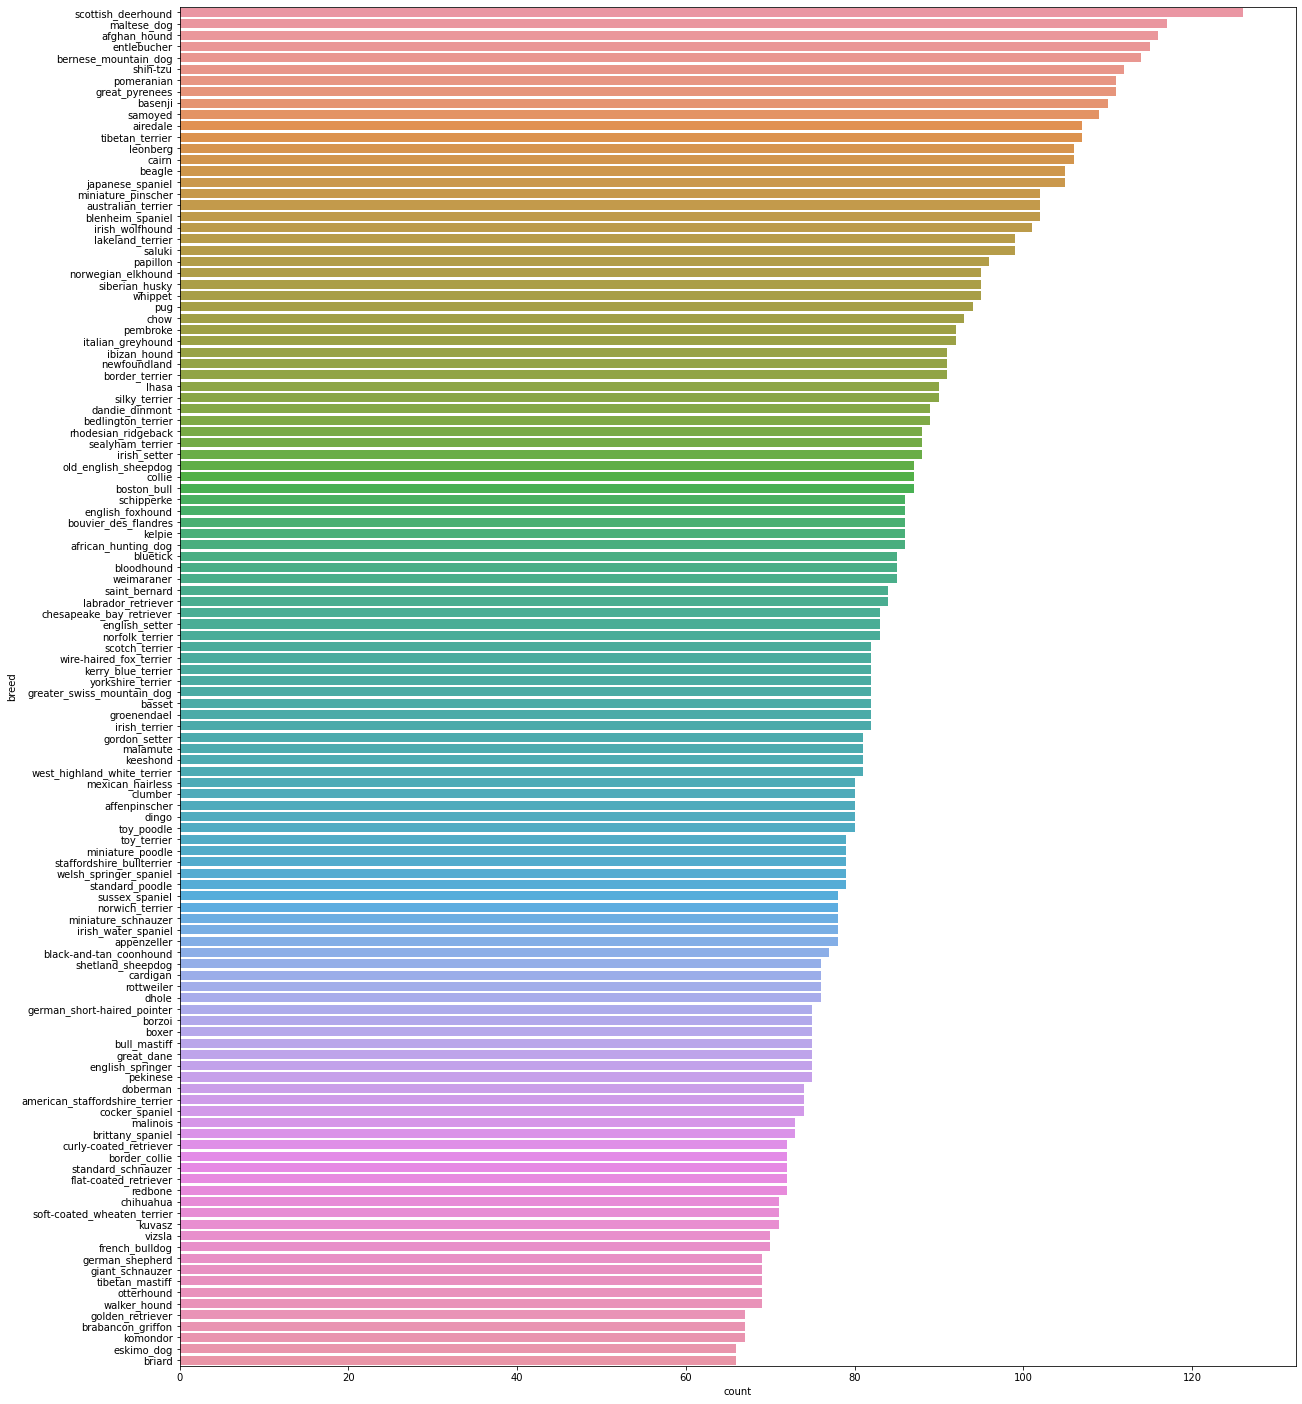

In [13]:
plt.figure(figsize=(20,25))
ax= sns.countplot(y='breed', data=labels_df, order=labels_df['breed'].value_counts().index)
plt.show()


- "scottish_deerhound" breed dog has highest count of images, 126.
- "briard" breed dog has least count of images, 66.

### Get one-hot encodings of labels

In [14]:
labels = np.array(pd.get_dummies(labels_df['breed']))

In [15]:
labels[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [16]:
img_rows = 128
img_columns = 128
num_channels = 3

In [17]:
from tqdm import tqdm
import cv2
x_train = []
y_train = []
i=0

for i, breed in tqdm(labels_df.values):
  train_img = cv2.imread('/content/train/{}.jpg'.format(i), 1)
  train_img_resize = cv2.resize(train_img, (img_rows, img_columns))
  x_train.append(train_img_resize)
  y_train.append(breed)

100%|██████████| 10222/10222 [00:31<00:00, 326.98it/s]


In [ ]:
y_train[1531]

'yorkshire_terrier'

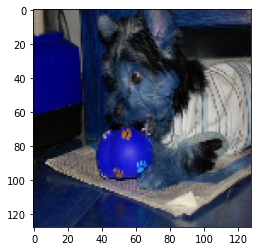

In [ ]:
plt.imshow(x_train[1531])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [18]:
x_train = np.asarray(x_train, dtype = np.float64)
x_train = x_train / 255

x_train = np.reshape(x_train, (len(x_train), img_rows, img_columns, num_channels))
x_train.shape

(10222, 128, 128, 3)

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [19]:
from sklearn.model_selection import train_test_split

(X_train, X_val, Y_train, Y_val) = train_test_split(x_train, y_train,	test_size=0.2, random_state=42)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [20]:
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [21]:
test_img = sample_submission['id']

Run the below code to load the test image files in x_test_feature

In [ ]:
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
   img = cv2.imread('/content/test/{}.jpg'.format(f), 1)
   img_resize = cv2.resize(img, (img_rows, img_columns)) 
   x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:29<00:00, 353.30it/s]


Normalize the test data and convert it into 4 dimensions

In [ ]:
x_test_feature = np.asarray(x_test_feature, dtype = np.float64)
x_test_feature /= 255
x_test_feature.shape

(10357, 128, 128, 3)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [ ]:
# Initialize Sequential model
model = Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu',input_shape=(128,128,3)))

model.add(Conv2D(32, kernel_size=3, activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(120, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      18464     
_________________________________________________________________
flatten (Flatten)            (None, 476288)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               121929984 
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 121,984,152
Trainable params: 121,984,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_train = pd.get_dummies(y_train)
Y_val = pd.get_dummies(y_val)

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      18464     
_________________________________________________________________
flatten (Flatten)            (None, 476288)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               121929984 
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 121,984,152
Trainable params: 121,984,152
Non-trainable params: 0
_________________________________________________________________


### Use batch_size = 128 and epochs = 10 and execute the model

In [ ]:
model.fit(X_train, Y_train,          
          validation_data=(X_val, Y_val),
          epochs=10,
          batch_size=128)

Epoch 1/10
64/64 [==============================] - 17s 123ms/step - loss: 7.5806 - accuracy: 0.0087 - val_loss: 4.7859 - val_accuracy: 0.0132
Epoch 2/10
64/64 [==============================] - 6s 95ms/step - loss: 4.7556 - accuracy: 0.0261 - val_loss: 4.7223 - val_accuracy: 0.0103
Epoch 3/10
64/64 [==============================] - 6s 95ms/step - loss: 4.0184 - accuracy: 0.1700 - val_loss: 5.1472 - val_accuracy: 0.0181
Epoch 4/10
64/64 [==============================] - 6s 95ms/step - loss: 1.7012 - accuracy: 0.6376 - val_loss: 7.9781 - val_accuracy: 0.0220
Epoch 5/10
64/64 [==============================] - 6s 95ms/step - loss: 0.3345 - accuracy: 0.9370 - val_loss: 11.6115 - val_accuracy: 0.0244
Epoch 6/10
64/64 [==============================] - 6s 95ms/step - loss: 0.1056 - accuracy: 0.9858 - val_loss: 11.4410 - val_accuracy: 0.0249
Epoch 7/10
64/64 [==============================] - 6s 95ms/step - loss: 0.0683 - accuracy: 0.9942 - val_loss: 12.9811 - val_accuracy: 0.0215
Epoch 8/

- The model accuracy is very poor. 
- accuracy is 99.79% and val_accuracy is 2.54%

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True)

In [ ]:

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                              rotation_range=20,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2)


### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [ ]:
train_generator = train_datagen.flow(X_train, Y_train)
val_generator = val_datagen.flow(X_val, Y_val)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [ ]:
model.fit_generator(train_generator,
                    epochs = 10,
                    steps_per_epoch = len(X_train) // 128,
                    validation_data = val_generator,
                    validation_steps = len(X_val) // 128)

Epoch 1/10
63/63 [==============================] - 10s 158ms/step - loss: 5.0305 - accuracy: 0.0109 - val_loss: 4.7923 - val_accuracy: 0.0083
Epoch 2/10
63/63 [==============================] - 10s 153ms/step - loss: 4.7850 - accuracy: 0.0105 - val_loss: 4.7842 - val_accuracy: 0.0125
Epoch 3/10
63/63 [==============================] - 10s 153ms/step - loss: 4.7818 - accuracy: 0.0099 - val_loss: 4.7827 - val_accuracy: 0.0229
Epoch 4/10
63/63 [==============================] - 9s 151ms/step - loss: 4.7828 - accuracy: 0.0095 - val_loss: 4.7793 - val_accuracy: 0.0146
Epoch 5/10
63/63 [==============================] - 9s 149ms/step - loss: 4.7814 - accuracy: 0.0115 - val_loss: 4.7841 - val_accuracy: 0.0083
Epoch 6/10
63/63 [==============================] - 10s 152ms/step - loss: 4.7822 - accuracy: 0.0109 - val_loss: 4.7841 - val_accuracy: 0.0104
Epoch 7/10
63/63 [==============================] - 10s 151ms/step - loss: 4.7759 - accuracy: 0.0104 - val_loss: 4.7807 - val_accuracy: 0.0125
E

- After data augumentation, still the model accuracy is poor.
- accuracy is 1.14% and val_accuracy is 0.83%

# Model accuracy is still poor!!!

In [ ]:
tf.keras.backend.clear_session()

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('/content/drive/MyDrive/Colab Notebooks/Computer Vision Project/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [ ]:
x = Flatten()(base_model.output)

x = Dense(1024, activation='relu')(x)

x = Dense(256, activation='relu')(x)

x = Dense(120, activation='softmax')(x)

vgg16_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

### Make all the layers in the base_model (VGG16) to be non-trainable

In [ ]:
#Set pre-trained model layers to not trainable
for layer in vgg16_model.layers[:17]:
    layer.trainable = False

In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [ ]:
vgg16_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
vgg16_model.fit_generator(train_generator,
                    epochs = 10,
                    steps_per_epoch = len(X_train) // 128,
                    validation_data = val_generator,
                    validation_steps = len(X_val) // 128)

Epoch 1/10
63/63 [==============================] - 12s 159ms/step - loss: 4.8682 - accuracy: 0.0059 - val_loss: 4.7951 - val_accuracy: 0.0125
Epoch 2/10
63/63 [==============================] - 10s 155ms/step - loss: 4.7799 - accuracy: 0.0185 - val_loss: 4.7085 - val_accuracy: 0.0333
Epoch 3/10
63/63 [==============================] - 10s 156ms/step - loss: 4.6424 - accuracy: 0.0276 - val_loss: 4.5833 - val_accuracy: 0.0417
Epoch 4/10
63/63 [==============================] - 10s 152ms/step - loss: 4.4066 - accuracy: 0.0448 - val_loss: 4.2985 - val_accuracy: 0.0458
Epoch 5/10
63/63 [==============================] - 10s 152ms/step - loss: 4.1253 - accuracy: 0.0786 - val_loss: 4.0555 - val_accuracy: 0.0750
Epoch 6/10
63/63 [==============================] - 10s 153ms/step - loss: 3.9286 - accuracy: 0.1004 - val_loss: 3.8795 - val_accuracy: 0.1063
Epoch 7/10
63/63 [==============================] - 10s 152ms/step - loss: 3.7564 - accuracy: 0.1243 - val_loss: 3.8911 - val_accuracy: 0.1187

- The accuarcy is 14.68% and the val_accuracy is 15%
- Although both accuracy and val_accuracy are pretty close, they are very less.

### Adding Batch Norm and Dropout layers

In [ ]:
x = BatchNormalization()(base_model.output)

x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.5)(x)

x = Dense(120, activation='softmax')(x)

vgg_model_2 = tf.keras.models.Model(inputs=base_model.input,outputs=x)

In [ ]:
#Set pre-trained model layers to not trainable
for layer in vgg_model_2.layers[:17]:
    layer.trainable = False

In [ ]:
# Making some layers trainable
vgg_model_2.layers[15].trainable = True
vgg_model_2.layers[16].trainable = True
vgg_model_2.layers[17].trainable = True

In [ ]:
vgg_model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
vgg_model_2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
vgg_model_2.fit(X_train, Y_train ,validation_data=(X_val,Y_val), epochs=10,batch_size=128)

Epoch 1/10
64/64 [==============================] - 21s 239ms/step - loss: 5.7951 - accuracy: 0.0113 - val_loss: 5.5111 - val_accuracy: 0.0064
Epoch 2/10
64/64 [==============================] - 7s 107ms/step - loss: 5.2133 - accuracy: 0.0187 - val_loss: 4.7038 - val_accuracy: 0.0147
Epoch 3/10
64/64 [==============================] - 7s 108ms/step - loss: 4.7374 - accuracy: 0.0343 - val_loss: 4.5880 - val_accuracy: 0.0308
Epoch 4/10
64/64 [==============================] - 7s 107ms/step - loss: 4.4043 - accuracy: 0.0496 - val_loss: 9.4676 - val_accuracy: 0.0064
Epoch 5/10
64/64 [==============================] - 7s 107ms/step - loss: 4.3609 - accuracy: 0.0486 - val_loss: 4.2070 - val_accuracy: 0.0611
Epoch 6/10
64/64 [==============================] - 7s 107ms/step - loss: 4.0294 - accuracy: 0.0689 - val_loss: 4.1426 - val_accuracy: 0.0621
Epoch 7/10
64/64 [==============================] - 7s 107ms/step - loss: 3.8322 - accuracy: 0.0880 - val_loss: 4.4081 - val_accuracy: 0.0557
Epoch

In [ ]:
vgg_model_2.fit(X_train, Y_train ,validation_data=(X_val,Y_val), epochs=50,batch_size=128, initial_epoch=10)

Epoch 11/50
64/64 [==============================] - 7s 111ms/step - loss: 3.0771 - accuracy: 0.1887 - val_loss: 3.8556 - val_accuracy: 0.1125
Epoch 12/50
64/64 [==============================] - 7s 107ms/step - loss: 2.9113 - accuracy: 0.2110 - val_loss: 8.5917 - val_accuracy: 0.0352
Epoch 13/50
64/64 [==============================] - 7s 107ms/step - loss: 2.6834 - accuracy: 0.2550 - val_loss: 4.0150 - val_accuracy: 0.1262
Epoch 14/50
64/64 [==============================] - 7s 107ms/step - loss: 2.4972 - accuracy: 0.2880 - val_loss: 4.6631 - val_accuracy: 0.0870
Epoch 15/50
64/64 [==============================] - 7s 107ms/step - loss: 2.2438 - accuracy: 0.3488 - val_loss: 4.1147 - val_accuracy: 0.1335
Epoch 16/50
64/64 [==============================] - 7s 107ms/step - loss: 2.0075 - accuracy: 0.3998 - val_loss: 4.2988 - val_accuracy: 0.0988
Epoch 17/50
64/64 [==============================] - 7s 107ms/step - loss: 1.8161 - accuracy: 0.4456 - val_loss: 4.5918 - val_accuracy: 0.1276

In [ ]:
vgg_model_2.fit(X_train, Y_train ,validation_data=(X_val,Y_val), epochs=75,batch_size=128, initial_epoch=50)


Epoch 51/75
64/64 [==============================] - 8s 120ms/step - loss: 0.1286 - accuracy: 0.9596 - val_loss: 6.4004 - val_accuracy: 0.1433
Epoch 52/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1235 - accuracy: 0.9598 - val_loss: 6.8985 - val_accuracy: 0.2152
Epoch 53/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1315 - accuracy: 0.9596 - val_loss: 7.1034 - val_accuracy: 0.1936
Epoch 54/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1231 - accuracy: 0.9631 - val_loss: 7.3635 - val_accuracy: 0.1892
Epoch 55/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1289 - accuracy: 0.9604 - val_loss: 6.8183 - val_accuracy: 0.2103
Epoch 56/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1153 - accuracy: 0.9650 - val_loss: 7.2178 - val_accuracy: 0.1917
Epoch 57/75
64/64 [==============================] - 7s 107ms/step - loss: 0.1144 - accuracy: 0.9669 - val_loss: 6.9905 - val_accuracy: 0.2142

In [ ]:
vgg_model_2.fit(X_train, Y_train ,validation_data=(X_val,Y_val), epochs=100,batch_size=128, initial_epoch=75)


Epoch 76/100
64/64 [==============================] - 7s 113ms/step - loss: 0.0946 - accuracy: 0.9700 - val_loss: 7.9851 - val_accuracy: 0.1976
Epoch 77/100
64/64 [==============================] - 7s 108ms/step - loss: 0.0904 - accuracy: 0.9724 - val_loss: 7.5598 - val_accuracy: 0.2142
Epoch 78/100
64/64 [==============================] - 7s 108ms/step - loss: 0.1025 - accuracy: 0.9676 - val_loss: 7.3804 - val_accuracy: 0.2098
Epoch 79/100
64/64 [==============================] - 7s 108ms/step - loss: 0.0896 - accuracy: 0.9732 - val_loss: 7.9754 - val_accuracy: 0.1990
Epoch 80/100
64/64 [==============================] - 7s 108ms/step - loss: 0.0910 - accuracy: 0.9714 - val_loss: 7.9821 - val_accuracy: 0.1907
Epoch 81/100
64/64 [==============================] - 7s 107ms/step - loss: 0.0985 - accuracy: 0.9687 - val_loss: 7.8829 - val_accuracy: 0.2005
Epoch 82/100
64/64 [==============================] - 7s 108ms/step - loss: 0.0896 - accuracy: 0.9733 - val_loss: 7.6202 - val_accuracy:

- After training VGG16 model for 100 epochs, we can see that the Training accuracy increased to around 97.84% but validation accuracy is still hovering around 20%. The model is overfitting on Training data but not performing well in general.

### Using Pretrained models

Keras contains 10 pretrained models for image classification which are trained on Imagenet data. Imagenet is a large collection of image data containing 1000 categories of images. These pretrained models are capable of classifying any image that falls into these 1000 categories of images.


#### MODEL - 1

img_size = (128,128,3)

Using InceptionV3, Xception and InceptionResNetV2

In [22]:
tf.keras.backend.clear_session()

In [23]:
img_size = (128,128,3)

In [24]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import os

def images_to_array(directory, label_dataframe, target_size = (128, 128, 3)):
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
    img = ''
    for ix, image_name in enumerate(label_dataframe['id'].values):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img_to_array(img)
    del img
    return images

In [25]:
train_path='/content/train'

In [26]:
X_features = images_to_array(train_path,labels_df, img_size)

In [27]:
y_features = pd.get_dummies(y_train)

In [28]:
from keras.layers import Lambda, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [29]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X_features)

320/320 [==============================] - 39s 22ms/step
Feature maps shape:  (10222, 2048)


In [30]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inception_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X_features)

320/320 [==============================] - 20s 51ms/step
Feature maps shape:  (10222, 1536)


In [31]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X_features)

320/320 [==============================] - 9s 25ms/step
Feature maps shape:  (10222, 2048)


In [32]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 inception_resnet_features,], axis=-1) 
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 5632)


In [33]:
from keras.callbacks import EarlyStopping
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [36]:
from keras.models import Sequential
model_1 = Sequential()
model_1.add(InputLayer(final_features.shape[1:]))
model_1.add(Dropout(0.5))
model_1.add(Dense(120,activation='softmax'))

model_1.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history_1 = model_1.fit(final_features,
                  y_features,
                  batch_size=32,
                  epochs=50,
                  validation_split=0.3,
                  callbacks=[EarlyStop_callback])

Epoch 1/50
224/224 [==============================] - 2s 5ms/step - loss: 8.2015 - accuracy: 0.2411 - val_loss: 4.6208 - val_accuracy: 0.5109
Epoch 2/50
224/224 [==============================] - 1s 4ms/step - loss: 3.6908 - accuracy: 0.5626 - val_loss: 4.8532 - val_accuracy: 0.5269
Epoch 3/50
224/224 [==============================] - 1s 4ms/step - loss: 2.9250 - accuracy: 0.6356 - val_loss: 4.7894 - val_accuracy: 0.5481
Epoch 4/50
224/224 [==============================] - 1s 4ms/step - loss: 2.2047 - accuracy: 0.7176 - val_loss: 4.8900 - val_accuracy: 0.5621
Epoch 5/50
224/224 [==============================] - 1s 4ms/step - loss: 1.7544 - accuracy: 0.7535 - val_loss: 5.4437 - val_accuracy: 0.5514
Epoch 6/50
224/224 [==============================] - 1s 4ms/step - loss: 1.6659 - accuracy: 0.7702 - val_loss: 5.9122 - val_accuracy: 0.5406
Epoch 7/50
224/224 [==============================] - 1s 4ms/step - loss: 1.3620 - accuracy: 0.8016 - val_loss: 5.7798 - val_accuracy: 0.5631
Epoch 

- accuracy is 85.29 and val_accuracy is 56.99
- There is a significant difference in accuracy and val_accuracy

#### MODEL - 2

img_size = (128,128,3)

Using InceptionV3, Xception and InceptionResNetV2

Multiple Dense, BatchNorm and Dropout layers are added.

In [34]:
from keras.layers import Lambda, Dropout, InputLayer, Input

model_2 = Sequential()
model_2.add(InputLayer(final_features.shape[1:]))
model_2.add(Dense(1028,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.25))
model_2.add(Dense(512, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))
model_2.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.7))
model_2.add(Dense(120,activation= 'softmax'))

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model_2.fit(final_features, y_features,
            batch_size=128,
            epochs=30,
            validation_split=0.3,
            callbacks=[EarlyStop_callback])

Epoch 1/30
56/56 [==============================] - 3s 21ms/step - loss: 5.7234 - accuracy: 0.0213 - val_loss: 4.7877 - val_accuracy: 0.1030
Epoch 2/30
56/56 [==============================] - 0s 9ms/step - loss: 4.2515 - accuracy: 0.1037 - val_loss: 2.6038 - val_accuracy: 0.3838
Epoch 3/30
56/56 [==============================] - 0s 9ms/step - loss: 3.5621 - accuracy: 0.1891 - val_loss: 2.1955 - val_accuracy: 0.4760
Epoch 4/30
56/56 [==============================] - 0s 9ms/step - loss: 3.1698 - accuracy: 0.2505 - val_loss: 2.0395 - val_accuracy: 0.4917
Epoch 5/30
56/56 [==============================] - 0s 9ms/step - loss: 2.8410 - accuracy: 0.3132 - val_loss: 1.8959 - val_accuracy: 0.5142
Epoch 6/30
56/56 [==============================] - 0s 9ms/step - loss: 2.6288 - accuracy: 0.3505 - val_loss: 1.8046 - val_accuracy: 0.5298
Epoch 7/30
56/56 [==============================] - 0s 9ms/step - loss: 2.4592 - accuracy: 0.3792 - val_loss: 1.7815 - val_accuracy: 0.5344
Epoch 8/30
56/56 [=

- After adding multiple dense, batch norm and dropout layers, the accuracy is 63.01% and val_accuracy is 57.06%
- the accuracy and val_accuracy are not so different.

#### MODEL - 3

The image size is changed.

img_size = (256,256,3)

Using InceptionV3, Xception and InceptionResNetV2


In [37]:
new_img_size = (256, 256,3)

In [38]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import os

def images_to_array(directory, label_dataframe, target_size = (256, 256, 3)):
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
    img = ''
    for ix, image_name in enumerate(label_dataframe['id'].values):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img_to_array(img)
    del img
    return images

In [40]:
X_features_new = images_to_array(train_path,labels_df, new_img_size)

In [41]:
# inception features
inception_features_new = get_features(InceptionV3,
                                  inception_preprocessor,
                                  new_img_size, X_features_new)
# xception features
xception_features_new = get_features(Xception,
                                 xception_preprocessor,
                                 new_img_size, X_features_new)

# inception resnet features
inception_resnet_features_new = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   new_img_size, X_features_new)

320/320 [==============================] - 18s 50ms/step
Feature maps shape:  (10222, 2048)
320/320 [==============================] - 30s 91ms/step
Feature maps shape:  (10222, 2048)
320/320 [==============================] - 43s 123ms/step
Feature maps shape:  (10222, 1536)


In [43]:
final_features_new = np.concatenate([inception_features_new,
                                 xception_features_new,
                                 inception_resnet_features_new,], axis=-1) 
print('Final feature maps shape', final_features_new.shape)

Final feature maps shape (10222, 5632)


In [44]:
model_3 = Sequential()
model_3.add(InputLayer(final_features_new.shape[1:]))
model_3.add(Dense(1028,activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))
model_3.add(Dense(512, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.7))
model_3.add(Dense(120,activation= 'softmax'))

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_3 = model_3.fit(final_features_new, y_features,
            batch_size=128,
            epochs=30,
            validation_split=0.3,
            callbacks=[EarlyStop_callback])

Epoch 1/30
56/56 [==============================] - 2s 15ms/step - loss: 5.2433 - accuracy: 0.0522 - val_loss: 2.6872 - val_accuracy: 0.4643
Epoch 2/30
56/56 [==============================] - 0s 9ms/step - loss: 2.9964 - accuracy: 0.2953 - val_loss: 1.0910 - val_accuracy: 0.7988
Epoch 3/30
56/56 [==============================] - 0s 9ms/step - loss: 2.1850 - accuracy: 0.4824 - val_loss: 0.6400 - val_accuracy: 0.8497
Epoch 4/30
56/56 [==============================] - 0s 9ms/step - loss: 1.6947 - accuracy: 0.6075 - val_loss: 0.5254 - val_accuracy: 0.8653
Epoch 5/30
56/56 [==============================] - 0s 9ms/step - loss: 1.3922 - accuracy: 0.6681 - val_loss: 0.4593 - val_accuracy: 0.8715
Epoch 6/30
56/56 [==============================] - 1s 9ms/step - loss: 1.1205 - accuracy: 0.7387 - val_loss: 0.4180 - val_accuracy: 0.8833
Epoch 7/30
56/56 [==============================] - 0s 9ms/step - loss: 1.0053 - accuracy: 0.7638 - val_loss: 0.4047 - val_accuracy: 0.8813
Epoch 8/30
56/56 [=

- After changing the image size, the accuracy is 90.16% and val_accuracy is 88.33%
- We can see a huge jump in both training and testing accuracy.

#### MODEL - 4

The image size is further increased.

img_size = (331,331,3)

Using InceptionV3, Xception, InceptionResNetV2 and NASNetLarge

Additional Dense, BatchNorm and Dropout layers are added.


In [53]:
final_img_shape=(331,331,3)


In [54]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import os

def images_to_array(directory, label_dataframe, target_size = (331, 331, 3)):
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
    img = ''
    for ix, image_name in enumerate(label_dataframe['id'].values):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img_to_array(img)
    del img
    return images

In [55]:
X_features_final = images_to_array(train_path,labels_df, final_img_shape)

In [56]:
# inception features
inception_features_final = get_features(InceptionV3,
                                  inception_preprocessor,
                                  final_img_shape, X_features_final)
# xception features
xception_features_final = get_features(Xception,
                                 xception_preprocessor,
                                 final_img_shape, X_features_final)

# inception resnet features
inception_resnet_features_final = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   final_img_shape, X_features_final)

# nasnet features
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features_final = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               final_img_shape, X_features_final)

320/320 [==============================] - 28s 81ms/step
Feature maps shape:  (10222, 2048)
320/320 [==============================] - 49s 150ms/step
Feature maps shape:  (10222, 2048)
320/320 [==============================] - 70s 207ms/step
Feature maps shape:  (10222, 1536)
320/320 [==============================] - 178s 538ms/step
Feature maps shape:  (10222, 4032)


In [57]:
FINAL_features = np.concatenate([inception_features_final,
                                 xception_features_final,
                                 inception_resnet_features_final,nasnet_features_final,], axis=-1) 
print('Final feature maps shape', FINAL_features.shape)

Final feature maps shape (10222, 9664)


In [58]:
final_model = Sequential()
final_model.add(InputLayer(FINAL_features.shape[1:]))
final_model.add(Dense(2056,activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.25))
final_model.add(Dense(1028,activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.3))
final_model.add(Dense(512, activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.4))
final_model.add(Dense(256, activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.5))
final_model.add(Dense(128, activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.5))
final_model.add(Dense(120,activation= 'softmax'))

final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the final_model
history_final = final_model.fit(FINAL_features, y_features,
            batch_size=256,
            epochs=30,
            validation_split=0.2,
            callbacks=[EarlyStop_callback])

Epoch 1/30
32/32 [==============================] - 3s 28ms/step - loss: 4.5087 - accuracy: 0.1037 - val_loss: 3.2948 - val_accuracy: 0.3252
Epoch 2/30
32/32 [==============================] - 0s 15ms/step - loss: 2.0993 - accuracy: 0.5919 - val_loss: 1.0366 - val_accuracy: 0.8577
Epoch 3/30
32/32 [==============================] - 0s 15ms/step - loss: 1.2347 - accuracy: 0.7962 - val_loss: 0.3824 - val_accuracy: 0.9213
Epoch 4/30
32/32 [==============================] - 0s 15ms/step - loss: 0.8008 - accuracy: 0.8687 - val_loss: 0.2745 - val_accuracy: 0.9291
Epoch 5/30
32/32 [==============================] - 0s 15ms/step - loss: 0.6070 - accuracy: 0.8980 - val_loss: 0.2392 - val_accuracy: 0.9311
Epoch 6/30
32/32 [==============================] - 0s 15ms/step - loss: 0.4897 - accuracy: 0.9119 - val_loss: 0.2379 - val_accuracy: 0.9364
Epoch 7/30
32/32 [==============================] - 0s 15ms/step - loss: 0.4060 - accuracy: 0.9256 - val_loss: 0.2352 - val_accuracy: 0.9335
Epoch 8/30
32

- After adding NasNetLarge as well, the accuracy is 97.19% and val_accuracy is 93.55%
- There is a significant jump in both training and testing accuracy.

### Conclusion

- The model performed poorly, even after addition of dropout and batch norm layers and also after data augumentation.
- It performed badly even after using VGG16 model. Also, we can try making  more layers of VGG16 model trainable because VGG16 was trained on different objects out of which one might be "Dog". But it might not have been trained on different breeds of dogs. This would increase the training time significantly.
- The model performance improved after using pretrained models.
- Best performance is observed when all the four InceptionV3, Xception, InceptionResNetV2 and NASNetLarge are used. The performance can be further increased by adding more dense, batch normalisation and dropout layers.

